In [58]:
import pandas as pd
import numpy as np
import os,csv
import matplotlib.pyplot as plt
import seaborn as sns
import os,cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,BatchNormalization,Input
from keras.preprocessing import image
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [59]:
path_data_train="data/train/"
path_data_test="data/test/"

In [60]:
data=[]

In [61]:
for folder in os.listdir(path_data_train):
    folder_path=os.path.join(path_data_train,folder)
    if os.path.isdir(folder_path):
        for image in os.listdir(folder_path):
            image_path=os.path.join(folder_path,image)
            if image.endswith(('.png','.jpg')):
                data.append({
                    "path":image_path,
                    "label":folder
                })

In [62]:
df=pd.DataFrame(data)
df.to_csv("data/mapping_label.csv",index=False,header=True)
df

,path,label
0,data/train/angry/Training_10118481.jpg,angry
1,data/train/angry/Training_10120469.jpg,angry
2,data/train/angry/Training_10131352.jpg,angry
3,data/train/angry/Training_10161559.jpg,angry
4,data/train/angry/Training_1021836.jpg,angry
...,...,...
28704,data/train/surprise/Training_99916297.jpg,surprise
28705,data/train/surprise/Training_99924420.jpg,surprise
28706,data/train/surprise/Training_99937001.jpg,surprise
28707,data/train/surprise/Training_99951755.jpg,surprise


In [63]:
name_duplicated=df.duplicated(subset=['path']).sum()
name_duplicated

0

In [64]:
# randomize
df=df.sample(frac=1,random_state=42).reset_index(drop=True)
df

,path,label
0,data/train/fear/Training_22695598.jpg,fear
1,data/train/happy/Training_47178464.jpg,happy
2,data/train/surprise/Training_76747047.jpg,surprise
3,data/train/fear/Training_22757966.jpg,fear
4,data/train/surprise/Training_78696030.jpg,surprise
...,...,...
28704,data/train/sad/Training_25755162.jpg,sad
28705,data/train/fear/Training_31740082.jpg,fear
28706,data/train/angry/Training_29393434.jpg,angry
28707,data/train/neutral/Training_10904555.jpg,neutral


In [65]:
df.describe()

,path,label
count,28709,28709
unique,28709,7
top,data/train/fear/Training_22695598.jpg,happy
freq,1,7215


In [66]:
labels_count=df['label'].value_counts()
labels_count

label
happy       7215
neutral     4965
sad         4830
fear        4097
angry       3995
surprise    3171
disgust      436
Name: count, dtype: int64

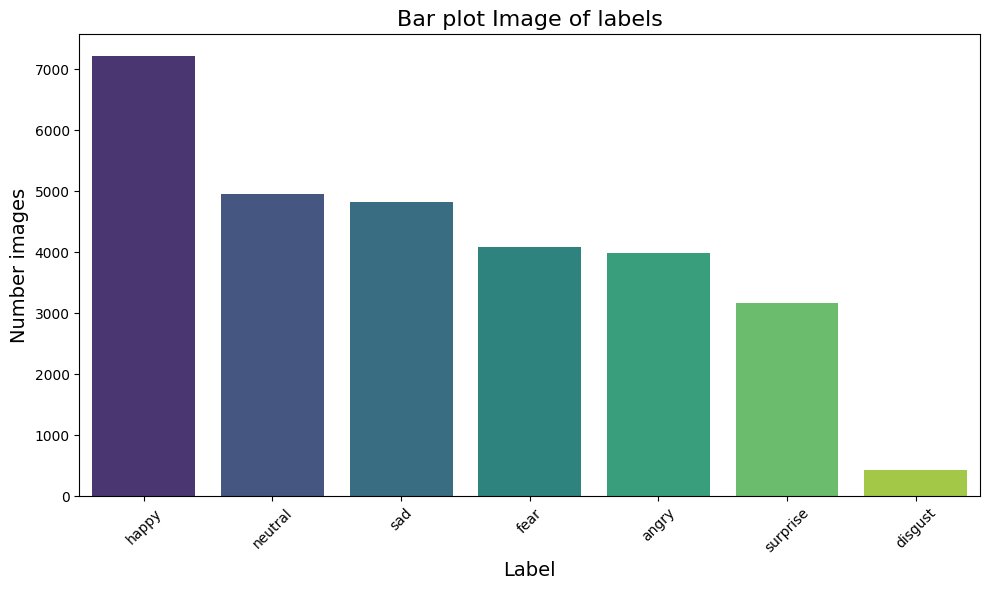

In [67]:
plt.figure(figsize=(10, 6))
sns.barplot(x=labels_count.index, y=labels_count.values, palette="viridis")
plt.title("Bar plot Image of labels", fontsize=16)
plt.xlabel("Label", fontsize=14)
plt.ylabel("Number images", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

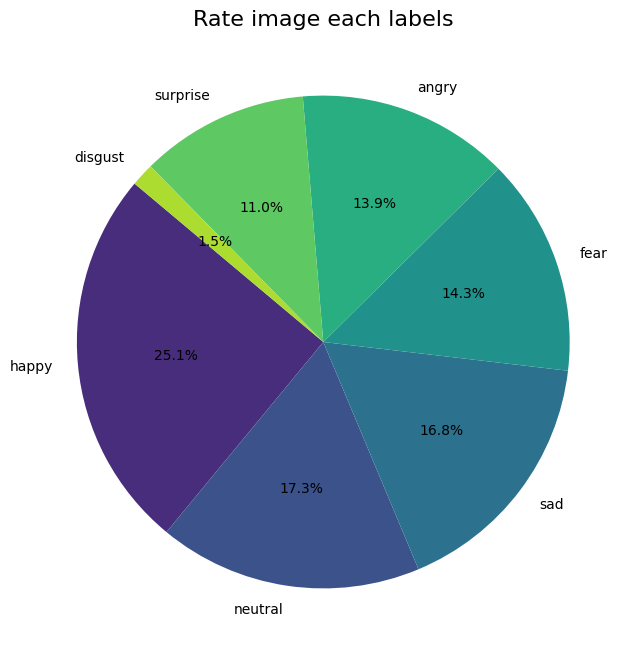

In [68]:
plt.figure(figsize=(8, 8))
plt.pie(labels_count, labels=labels_count.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis", len(labels_count)))
plt.title("Rate image each labels", fontsize=16)
plt.show()

**Evaluate**
- Emotion Distribution: The dataset includes 7 emotional labels, which makes it diverse and well-suited for training an emotion recognition model.

- Class Imbalance: There’s a significant imbalance in the dataset, with "happy" being the most prevalent class and "disgust" having very few samples. This imbalance might lead to a biased model if not addressed properly.

- Application Potential: This dataset has great potential for building applications like emotion-based chatbots, user feedback analysis systems, or psychological research tools.

In [69]:
# check shape
unique_shape=set()
for index,row in tqdm(df.iterrows()):
    img_shape=cv2.imread(row['path']).shape
    unique_shape.add(img_shape)
    
unique_shape

28709it [00:02, 13739.93it/s]


{(48, 48, 3)}

In [70]:
for shape in unique_shape:
    image_h, image_w = shape[0], shape[1] # can handle  if have many shapes

image_h,image_w

(48, 48)

In [72]:
class Dataset:
    def __init__(self,data,label,image_w,image_h):
        self.data=data
        self.label=label
        self.image_w=image_w
        self.image_h=image_h
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,i):
        img_path=os.path.join(str(self.data.iloc[i]))
        img=image.load_img(img_path,target_size=(self.image_w,self.image_h))
        img=image.image_to_array(img)
        img=img/255.0
        label=self.label[i]
        return img,label

In [74]:
class DataLoader():
    def __init__(self,dataset,batch_size):
        self.dataset=dataset
        self.batch_size=batch_size
        self.size=np.arange(len(self.dataset))
    def __getitem__(self,i):
        batch_indexes=self.indexes[i*self.batch_size:(i+1)*self.batch_size] # get index batchsize
        batch_data=[self.dataset[idx] for idx in batch_indexes] # get image and label
        imgs, labels = zip(*batch_data)  
        return np.array(imgs), np.array(labels)

    def __len__(self):
        return (len(self.dataset) + self.batch_size - 1) // self.batch_size # return number of batchsize

    